# Program für Roboter- und Computervision

## Importieren der Bibliotheken

In [1]:
import cv2
import numpy as np 
from matplotlib import pyplot as plt

## Parameters

In [2]:
imagePath = "./Briefe/Download (3).jpg"
width = 1200 
height= 900

# winName1 = "original Image"
# winPos1 = [0,0]

# winName2 = "Blurred Image"
# winPos2 = [400,0]

# winName3 = "Gray"
# winPos3 = [800,0]

# winName4 = "Binary Image"
# winPos4 = [1200,0]

kernelSize = 25


https://pythonexamples.org/python-opencv-cv2-resize-image/

In [3]:
def showImage(name,picture,pos):
   
    # width = int(picture.shape[1] * scalePercent / 100)
    # height = int(picture.shape[0] * scalePercent / 100)
    dsize = (width, height)
    output = cv2.resize(picture, dsize)
    cv2.namedWindow(name)
    cv2.startWindowThread()
    cv2.moveWindow(name,pos[0],pos[1])
    cv2.imshow(name,output)
    # plt.imshow(output)
    

## Vorbereitung des Bildes

Text(0.5, 1.0, 'Original')

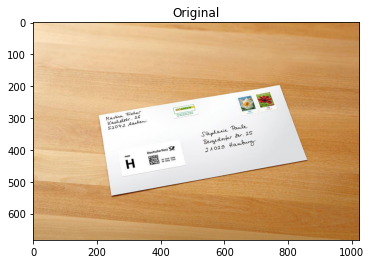

In [4]:

    # Lesen des Bilds
image = cv2.imread(imagePath, cv2.IMREAD_COLOR)
showImage = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    # Zeigen des Bilds
# showImage(winName1,image,winPos1)
plt.imshow(showImage)
plt.title("Original")
# showImage(winName2,blurred,winPos2)

Text(0.5, 1.0, 'blurred')

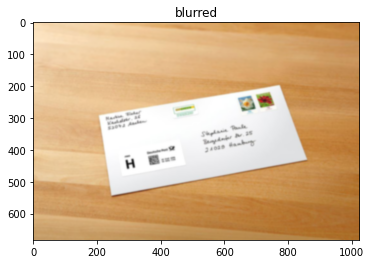

In [5]:
    # Gausian Blur
blurred  = cv2.GaussianBlur(image,(kernelSize,kernelSize) , 2, 2,cv2.THRESH_BINARY)
blurredShow = cv2.cvtColor(blurred, cv2.COLOR_BGR2RGB)
plt.imshow(blurredShow)
plt.title("blurred")

## Binarisierung
https://www.geeksforgeeks.org/python-thresholding-techniques-using-opencv-set-3-otsu-thresholding/

Text(0.5, 1.0, 'Gray')

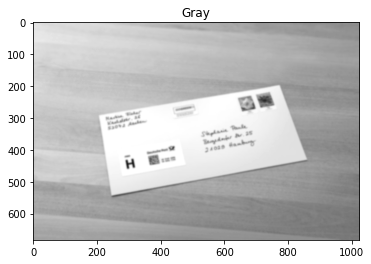

In [6]:
# thresh1 = cv2.adaptiveThreshold(blurred,255,125,cv2.THRESH_BINARY,11,5)
gray = cv2.cvtColor(blurred, cv2.COLOR_BGR2GRAY) 
plt.imshow(gray, cmap="gray", vmin=0, vmax=255)
plt.title("Gray")

Text(0.5, 1.0, 'Canny')

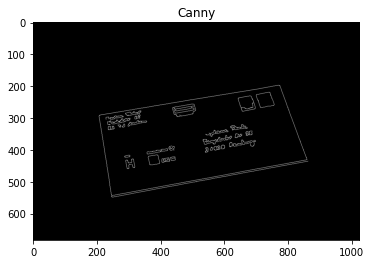

In [7]:
canny = cv2.Canny(gray,20,200)
height,width = canny.shape
plt.imshow(canny, cmap="gray")
plt.title("Canny")

In [8]:

# lines = cv2.HoughLines(canny,1,np.pi/180,200)
img,contours,hierachy = cv2.findContours(canny,cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)
# Hierarchie [Previous, Next, Child, Parent]

In [9]:
for contour in contours:
    print(contour.size)

288
4916
202
364
92
122
80
70
224
216
190
182
8
104
90
86
74
96
8
132
76
250
72
64
54
50
120
144
80
502
94
286
42
146
306
58
54
162
12
216
64
100
54
282
108
228
326
32
84
242
100
332
126
122
90
558
102
78
104
80
22
142
100
66
362
364
362
1166
46
416
328
322
4176


In [10]:
parent= np.zeros((height,width))
parent_countours = []
for index,item in enumerate(hierachy):
    print(item)
    if(item[0][3]==-1):
        print(item)
        parent_countours.append(contours[index])
print(parent_countours[0].size)

[[ 1 -1 -1 -1]
 [ 2  0 -1 -1]
 [ 3  1 -1 -1]
 [ 4  2 -1 -1]
 [ 6  3  5 -1]
 [-1 -1 -1  4]
 [ 8  4  7 -1]
 [-1 -1 -1  6]
 [10  6  9 -1]
 [-1 -1 -1  8]
 [12  8 11 -1]
 [-1 -1 -1 10]
 [13 10 -1 -1]
 [15 12 14 -1]
 [-1 -1 -1 13]
 [17 13 16 -1]
 [-1 -1 -1 15]
 [19 15 18 -1]
 [-1 -1 -1 17]
 [20 17 -1 -1]
 [21 19 -1 -1]
 [22 20 -1 -1]
 [24 21 23 -1]
 [-1 -1 -1 22]
 [25 22 -1 -1]
 [26 24 -1 -1]
 [27 25 -1 -1]
 [28 26 -1 -1]
 [29 27 -1 -1]
 [30 28 -1 -1]
 [31 29 -1 -1]
 [32 30 -1 -1]
 [33 31 -1 -1]
 [34 32 -1 -1]
 [35 33 -1 -1]
 [36 34 -1 -1]
 [37 35 -1 -1]
 [38 36 -1 -1]
 [39 37 -1 -1]
 [40 38 -1 -1]
 [41 39 -1 -1]
 [42 40 -1 -1]
 [43 41 -1 -1]
 [44 42 -1 -1]
 [45 43 -1 -1]
 [46 44 -1 -1]
 [48 45 47 -1]
 [-1 -1 -1 46]
 [49 46 -1 -1]
 [50 48 -1 -1]
 [51 49 -1 -1]
 [52 50 -1 -1]
 [53 51 -1 -1]
 [54 52 -1 -1]
 [55 53 -1 -1]
 [56 54 -1 -1]
 [57 55 -1 -1]
 [58 56 -1 -1]
 [59 57 -1 -1]
 [60 58 -1 -1]
 [61 59 -1 -1]
 [62 60 -1 -1]
 [63 61 -1 -1]
 [64 62 -1 -1]
 [65 63 -1 -1]
 [66 64 -1 -1]
 [68 65 67

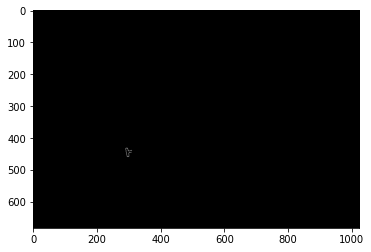

In [11]:
for point in parent_countours[0]:
    xPoint = point[0][0]
    yPoint = point[0][1]
    parent[yPoint,xPoint]=255
plt.imshow(parent,cmap="gray")

In [12]:
# cv2.waitKey(0)
# cv2.destroyAllWindows()

### Bekomme den Stream der Kamera und verwandle es in ein grau Stufen Bild
https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_gui/py_video_display/py_video_display.html?highlight=video

In [13]:
# cap = cv2.VideoCapture(0)

# while(True):
#     # Capture frame-by-frame
#     ret, frame = cap.read()

#     # Our operations on the frame come here
#     gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

#     # https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_canny/py_canny.html?highlight=imshow
#     #canny Edge Detection
#     edges = cv2.Canny(gray,100,200)
#     # 1 Fenster mit Graustufe
#     namedWindow1 = "gray"
#     cv2.namedWindow(namedWindow1)
#     cv2.moveWindow(namedWindow1,0,0)
#     cv2.imshow(namedWindow1, gray)
#     # 2 Fenster mit Kantenbild
#     namedWindow2 = "edges"
#     cv2.namedWindow(namedWindow2)
#     cv2.moveWindow(namedWindow2,640,0)
#     cv2.imshow(namedWindow2,edges)
#     # 3 Fenster 
#     namedWindow3 = "weiteres"
#     cv2.namedWindow(namedWindow3)
#     cv2.moveWindow(namedWindow3,1280,0)
#     cv2.imshow(namedWindow3,edges)


#     if cv2.waitKey(1) & 0xFF == ord('q'):
#         break

# # When everything done, release the capture
# cap.release()
# cv2.destroyAllWindows()